Инициализация MultiLabelBinarizer
Разделение на тренировочную и валидационную выборки
Инициализация модели


Some weights of BertForMultiLabelClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Тренировка модели
Epoch: 1/5


Train loss: 0.1423
Val loss: 0.0258
Precision: 1.0000
Recall: 1.0000
F1: 1.0000
✅ Новая модель! Сохраняем в папку multilabel_model
Epoch: 2/5


Train loss: 0.0200
Val loss: 0.0119
Precision: 1.0000
Recall: 1.0000
F1: 1.0000
✅ Новая модель! Сохраняем в папку multilabel_model
Epoch: 3/5


Train loss: 0.0112
Val loss: 0.0078
Precision: 1.0000
Recall: 1.0000
F1: 1.0000
✅ Новая модель! Сохраняем в папку multilabel_model
Epoch: 4/5


Train loss: 0.0081
Val loss: 0.0061
Precision: 1.0000
Recall: 1.0000
F1: 1.0000
✅ Новая модель! Сохраняем в папку multilabel_model
Epoch: 5/5


Train loss: 0.0068
Val loss: 0.0056
Precision: 1.0000
Recall: 1.0000
F1: 1.0000
✅ Новая модель! Сохраняем в папку multilabel_model
✅ Тренировка завершена!


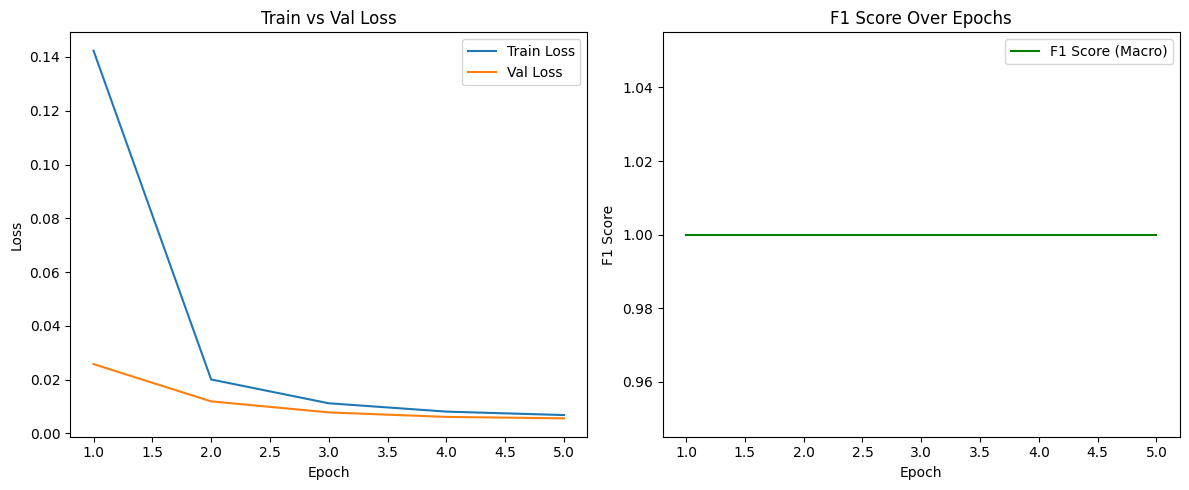

In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import BertTokenizer, get_scheduler
from torch.optim import AdamW
from model import BertForMultiLabelClassification
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import precision_score, recall_score, f1_score
import joblib
from preprocess import clean_text
from tqdm import tqdm
import os
import logging
from logging import config
import yaml

model_checkpoint = "bert-base-multilingual-cased"
num_epochs = 5
batch_size = 16
max_length = 128
learning_rate = 2e-5
device = "cuda" if torch.cuda.is_available() else "cpu"
save_dir = "multilabel_model"
validation_split = 0.1
logger_name = "train_classifier_multilabel"
confidence_threshold = 0.4

# with open('logging_config.yaml', 'r') as f:
#     config = yaml.safe_load(f.read())
#     logging.config.dictConfig(config)

# logger = logging.getLogger(logger_name)

df = pd.read_csv("dataset.csv")

df["text"] = df["text"].apply(clean_text)
df["labels"] = df["labels"].apply(lambda x: x.split(","))

mlb = MultiLabelBinarizer()
print("Инициализация MultiLabelBinarizer")
y = mlb.fit_transform(df["labels"])

os.makedirs(save_dir, exist_ok=True)
joblib.dump(mlb, os.path.join(save_dir, "mlb.pkl"))

tokenizer = BertTokenizer.from_pretrained(model_checkpoint)


class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=max_length,
            return_tensors="pt"
        )
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item


dataset = TextDataset(df["text"].tolist(), y)

val_size = int(len(dataset) * validation_split)
train_size = len(dataset) - val_size
print("Разделение на тренировочную и валидационную выборки")
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print("Инициализация модели")
model = BertForMultiLabelClassification.from_pretrained(model_checkpoint, num_labels=len(mlb.classes_))
model.to(device)

optimizer = AdamW(model.parameters(), lr=learning_rate)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer,
    num_warmup_steps=0, num_training_steps=len(train_loader) * num_epochs
)

best_val_loss = float('inf')

train_losses = []
val_losses = []
f1_scores = []

print("Тренировка модели")
for epoch in range(num_epochs):
    print(f"Epoch: {epoch + 1}/{num_epochs}")
    model.train()
    train_loss = 0.0

    loop = tqdm(train_loader, desc="Training", leave=False)
    for batch in loop:
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["labels"]
        )

        loss = outputs["loss"]
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    print(f"Train loss: {avg_train_loss:.4f}")

    all_preds = []
    all_labels = []

    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                labels=batch["labels"]
            )
            val_loss += outputs["loss"].item()

            logits = outputs["logits"]
            preds = torch.sigmoid(logits)  # применяем сигмоиду
            preds = (preds >= confidence_threshold).float()  # бинаризуем по порогу

            all_preds.append(preds.cpu())
            all_labels.append(batch["labels"].cpu())

    avg_val_loss = val_loss / len(val_loader)
    all_preds = torch.cat(all_preds, dim=0).numpy()
    all_labels = torch.cat(all_labels, dim=0).numpy()
    precision = precision_score(all_labels, all_preds, average="macro", zero_division=0)
    recall = recall_score(all_labels, all_preds, average="macro", zero_division=0)
    f1 = f1_score(all_labels, all_preds, average="macro", zero_division=0)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    f1_scores.append(f1)

    print(f"Val loss: {avg_val_loss:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1: {f1:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        print(f"✅ Новая модель! Сохраняем в папку {save_dir}")
        model.save_pretrained(save_dir)
        tokenizer.save_pretrained(save_dir)

print("✅ Тренировка завершена!")

import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Потери
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Val Loss')
plt.legend()

# F1-метрика
plt.subplot(1, 2, 2)
plt.plot(epochs, f1_scores, label='F1 Score (Macro)', color='green')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
train_list = [tuple(item.values()) for item in train_dataset]
val_list = [tuple(item.values()) for item in val_dataset]

common_elements = list(set(train_list) & set(val_list))

if len(common_elements) > 0:
    print(f"Найдено {len(common_elements)} общих элементов в train_dataset и val_dataset.")
else:
    print("train_dataset и val_dataset не содержат одинаковых записей.")


train_dataset и val_dataset не содержат одинаковых записей.
